# NURBS 2D (2)
### Abordagem por construção de classes de funções simbólicas

In [2]:
import sympy as sp
import pylab as pl
from AuxDisplay import *
from itertools import cycle

sp.init_printing(use_latex=True)

%matplotlib inline

In [3]:
x = sp.Symbol('x')

# Definindo funções bases B-Spline

## 2.1 - Funções B-spline

Para um vetor de knots $\Xi$:

\begin{equation}
    \Xi = [\xi_0, \xi_1, ..., \xi_{n+p+1}]
\end{equation}

A i-ésima função de base B-spline de grau p, denotada por $N_{i, p}(x)$, é definida como:

\begin{equation}
N_{i,0}(x) = \left\{
\begin{matrix} 
1 & \mathrm{se} \quad \xi_i \leq x < \xi_{i+1} \\
0 & \mathrm{c.c.} 
\end{matrix}
\right.
\end{equation}

Para $p = 1, 2, ...$, define-se:

\begin{equation}
N_{i,p}(x) = \frac{x - \xi_i}{\xi_{i+p} - \xi_i} N_{i,p-1}(x) + \frac{\xi_{i+p+1} - x}{\xi_{i+p+1} - \xi_{i+1}} N_{i+1,p-1}(x)
\end{equation}

In [4]:
class FuncaoSegm:
    '''Define funcoes simbolicas para cada intervalo entre dois knots'''
    cycol = cycle('bgrcmk')
    def __init__(s, knots, i, p = None):
        s.i = i
        s.p = p
        s.knots = knots
        s.ke = sp.zeros(len(knots)-1, 1)
        
    def plot(s, a='N'):
        s.cor = next(FuncaoSegm.cycol)
        for k in range(len(knots)-1):
            X = pl.linspace(knots[k], knots[k+1], 50)
            pl.plot(X, [s.ke[k].subs({x:xi}) for xi in X], label=('%s %d,%d'%(a, s.i, s.p) if k==0 else None), c = s.cor)
            
    def op_e(s, op, num):
        '''Retorna a FuncaoSegm operada com escalar'''
        fs = FuncaoSegm(s.knots, s.i, s.p)
        fs.ke = op(s.ke, num)
        return fs
    def mult_e(s, num): return s.op_e(lambda x, y: x*y, num)
    
    def op_fs(s, op, f):
        '''Retorna a FuncaoSegm dividida por outra'''
        fs = FuncaoSegm(s.knots, s.i, s.p)
        for k in range(len(s.ke)):
            fs.ke[k] = op(s.ke[k], f.ke[k])
        return fs
    def add_fs(s, f): return s.op_fs(lambda x, y: x+y, f)
    def div_fs(s, f): return s.op_fs(lambda x, y: x/y, f)
            
    def display(s, a='N'):
        displayEq('%s_{%d%d}'%(a, s.i, s.p), sp.Matrix(s.ke))

In [5]:
def funcoesBases(p, knots, plotar = False):
    '''Cria a n funcoes bases B-Spline de grau p para um vetor de knots
        N[grau][i-esima funcao][entre knots k e k+1]
    '''
    nk = len(knots)
    N = [ [ FuncaoSegm(knots, i, pi) for i in range(nk-1-pi)] for pi in range(p+1)]
    cycol = cycle('bgrcmk')
    
    # FIXME: o parametro recebido eh p, porem o primeiro for itera sobre uma variavel p
    for p, Np in enumerate(N):
        if plotar: pl.figure()
            
        for i in range(len(Np)):
            if p == 0:
                Np[i].ke[i] = 1
            else:
                if knots[i+p] != knots[i]:
                    Np[i] = Np[i].add_fs( N[p-1][i].mult_e( (x-knots[i])/(knots[i+p]-knots[i]) ) )
                if knots[i+p+1] != knots[i+1]:
                    Np[i] = Np[i].add_fs( N[p-1][i+1].mult_e((knots[i+p+1]-x)/(knots[i+p+1]-knots[i+1]) ) )
                Np[i].ke = Np[i].ke.expand()

            if plotar: Np[i].plot()
            # Npi.display()
                
        if plotar: plotShow('Funções de grau %d'%p)
            
    return N

In [6]:
def plotShow(title = None):
    if title is not None: pl.title(title)
    pl.grid()
    pl.legend(loc='best')
    pl.show() 

In [7]:
def plotFuncoesSeg(N, a='N', title = None): 
    for Ni in N: Ni.plot(a)
    plotShow(title)

In [8]:
def clamped_uniform_knots(inicio, fim, n, p):
    return [inicio]*p + list(pl.linspace(inicio, fim, n-p+1)) + [fim]*p

\Xi  = [0  0  0  1  2  3  4  4  5  5  5]

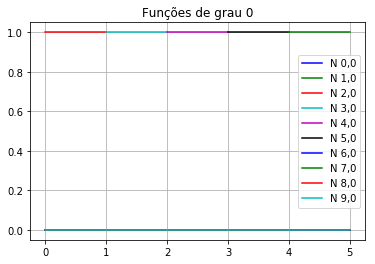

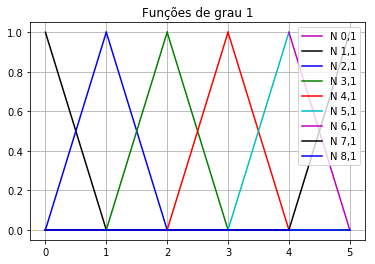

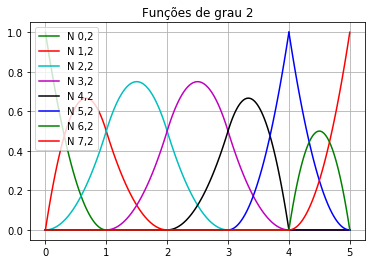

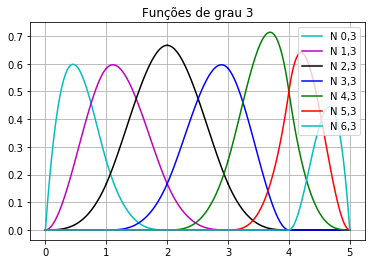

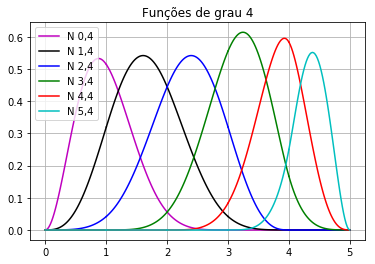

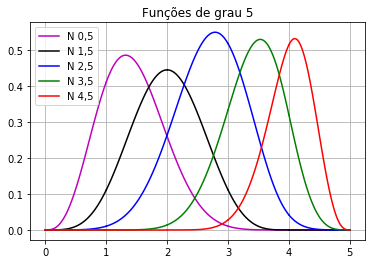

In [9]:
p = 5

knots = (0, 0, 0, 1, 2, 3, 4, 4, 5, 5, 5)
displayEq('\Xi', sp.Array(knots))

N = funcoesBases(p, knots, plotar=True)

### 2.1.1  - Curva B-spline
#### Construindo curva Spline para um conjunto de pontos

Uma curva B-spline de grau $p$ é definida como:

\begin{equation}
    \textbf{S}(x) =\sum_{i=0}^{n} N_{i,p}(x) \textbf{P}_i 
\end{equation}

In [9]:
def curvaSpline2D(pontos, knots, bases):
    '''Plota os vertices de controle e a curva dados os 
        pontos de controle, vetor de knots e funcoes bases'''
    Px, Py = pontos
    pl.plot(Px, Py, 'k--', label='Vertices de controle') # plotar vertices
    pl.plot(Px, Py, 'ro', label='Pontos de controle')  # plotar pontos
    
    nk = len(knots)
    Cx = FuncaoSegm(knots, bases[0].i, p)
    Cy = FuncaoSegm(knots, bases[0].i, p)
    for i, Ni in enumerate(bases):
        Cx = Cx.add_fs( Ni.mult_e(Px[i]) )
        Cy = Cy.add_fs( Ni.mult_e(Py[i]) )

    cor = next(FuncaoSegm.cycol)
    for k in range(nk-1):
        X = pl.linspace(knots[k], knots[k+1], 50)
        pl.plot([Cx.ke[k].subs({x:xi}) for xi in X],
                [Cy.ke[k].subs({x:xi}) for xi in X], c=cor)

    plotShow()

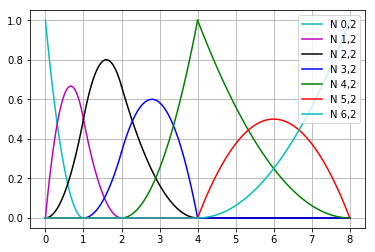

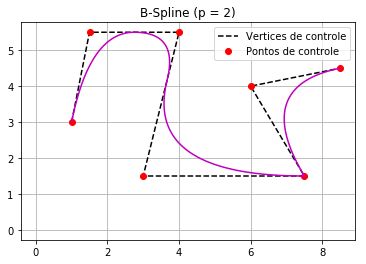

In [10]:
p = 2
knots = (0, 0, 0, 1, 2, 4, 4, 8, 8, 8)
N = funcoesBases(p, knots)[-1]
plotFuncoesSeg(N)

P = [[1.0, 1.5, 4.0, 3.0, 7.5, 6.0, 8.5],
     [3.0, 5.5, 5.5, 1.5, 1.5, 4.0, 4.5]]

pl.title('B-Spline (p = %d)'%p)
curvaSpline2D(P, knots, bases=N)

# Definindo funções NURBS

## 2.2 - Funções NURBS

### 2.2.1 - Curva NURBS

#### Exemplo 5

\Xi  = [0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0]

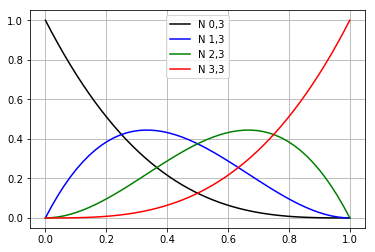

In [11]:
# knots = [0, 0, 0, 0, 1, 1, 1, 1]
p = 3
knots = clamped_uniform_knots(0.0, 1.0, n=4, p=p)
displayEq('\Xi', sp.Array(knots))

N = funcoesBases(p, knots, plotar=False)[-1]
plotFuncoesSeg(N)

### Atribuindo pesos às bases

In [12]:
def ponderarBase(base, W, plotar=False):
    nk = len(knots)
    sum_Nw = FuncaoSegm(base[0].knots, len(base), base[0].p)
    for Ni, wi in zip(base, W): 
        sum_Nw = sum_Nw.add_fs( Ni.mult_e( wi ) )
    n = len(W)
    R = [0]*n
    for i, Ni, wi in zip(range(n), base, W):
        R[i] = Ni.mult_e( wi ).op_fs(lambda x, y: x/y , sum_Nw)
    
    if plotar: plotFuncoesSeg(R, a='R', title='Funções de grau %d com pesos'%p)
        
    return R

w  = [1  0.333333333333333  0.75  1]

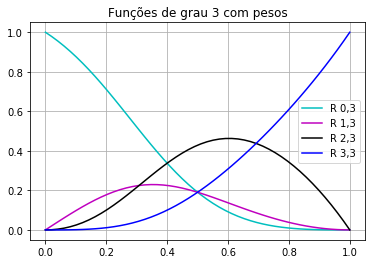

In [13]:
W = sp.Array([1, 1/3, 3/4, 1])
displayEq('w', W)
    
R = ponderarBase(N, W, plotar=True)

### Contruindo curva para um conjunto de pontos

Uma curva NURBS é definida como:

\begin{equation}
    \textbf{C}(x) =\sum_{i=0}^{n} R_{i,p}(x) \textbf{P}_i
\end{equation}

onde:

\begin{equation}
    R_{i,n}(x) = {N_{i,n}(x)w_i \over \sum_{j=0}^k N_{j,n}(x)w_j}
\end{equation}

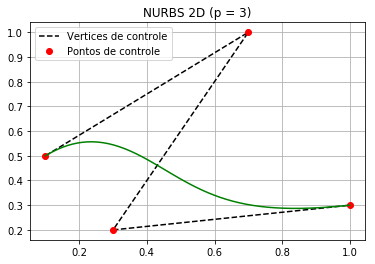

In [14]:
P = [[0.1, 0.7, 0.3, 1.0],
     [0.5, 1.0, 0.2, 0.3]]

# podemos utilizar a mesmo procedimento
pl.title('NURBS 2D (p = %d)'%p)
curvaSpline2D(P, knots, bases = R)

### Exemplo próprio

\Xi  = [0.0  0.0  0.2  0.4  0.6  0.8  1.0  1.0]

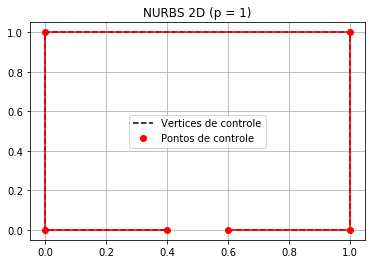

\Xi  = [0.0  0.0  0.0  0.25  0.5  0.75  1.0  1.0  1.0]

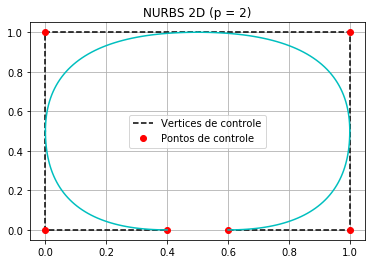

\Xi  = [0.0  0.0  0.0  0.0  0.333333333333333  0.666666666666667  1.0  1.0  1.
0  1.0]

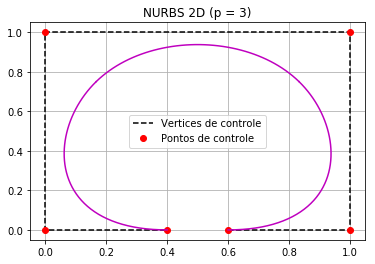

\Xi  = [0.0  0.0  0.0  0.0  0.0  0.5  1.0  1.0  1.0  1.0  1.0]

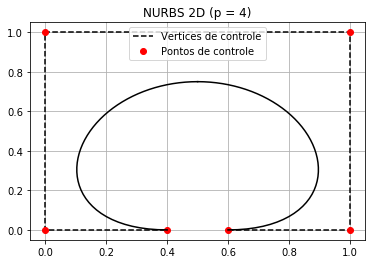

\Xi  = [0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0]

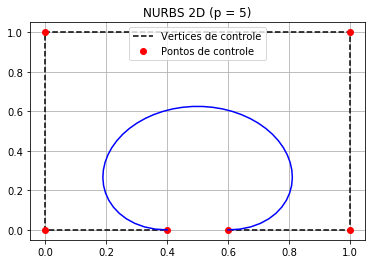

In [15]:
p_max = 5

for p in range(1, p_max+1):
    knots = clamped_uniform_knots(0.0, 1.0, n=6, p=p)
    displayEq('\Xi', sp.Array(knots))
    
    N = funcoesBases(p, knots, plotar=False)[-1]
    # plotFuncoesSeg(N)

    P = [[0.6, 1.0, 1.0, 0.0, 0.0, 0.4],
         [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]]

    # podemos utilizar a mesmo procedimento
    pl.title('NURBS 2D (p = %d)'%p)
    curvaSpline2D(P, knots, bases = N)

## [Rascunhos...]